In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
np.random.seed(2)

In [2]:
def create_dataset(N,random_seed=2):
    #X is an array of shape(2 features,Number of data=N), which contains scalar (0,40) m/s  and angle (0,90) degree respectively.
    #Y is an array of shape(2 output,Number of data=N), which contains Range and High, calculated by physics-based projectile formulae corresponding to angle and scalar in X.
    np.random.seed(random_seed)
    scalar = np.random.uniform(low=0,high=40,size=(1,N))
    angle = np.random.uniform(low=0,high=90,size=(1,N))
    X = np.concatenate((scalar,angle),axis=0)
    range = np.power(scalar,2)*np.sin(2*angle * np.pi / 180.)/9.8
    Height = np.power(scalar,2)*np.power(np.sin(angle * np.pi / 180.),2)/(2*9.8)
    Y=np.concatenate((range,Height),axis=0)
    return X,Y

In [3]:
def data_nomalization(X,Y,method='std'):
    if method =='std':
        X_mean=np.mean(X,axis=1,keepdims=True)
        X_std=np.std(X,axis=1,keepdims=True)
        Y_mean=np.mean(Y,axis=1,keepdims=True)
        Y_std=np.std(Y,axis=1,keepdims=True)
        X_nomalized=(X-X_mean)/X_std
        Y_nomalized=(Y-Y_mean)/Y_std
        cache=(X_mean,X_std,Y_mean,Y_std)
    elif method == 'max':
        X_max=np.max(X,axis=1,keepdims=True)
        Y_max=np.max(Y,axis=1,keepdims=True)
        X_nomalized=X/X_max
        Y_nomalized=Y/Y_max
        cache=(X_max,Y_max)
    return X_nomalized,Y_nomalized,cache

In [4]:
def compute_y(X):
    scalar=X[0,:].reshape(1,X.shape[1])
    angle=X[1,:].reshape(1,X.shape[1])
    range = np.power(scalar,2)*np.sin(2*angle * np.pi / 180.)/9.8
    Height = np.power(scalar,2)*np.power(np.sin(angle * np.pi / 180.),2)/(2*9.8)
    Y=np.concatenate((range,Height),axis=0)
    return Y

In [5]:
def initialize_parameters_deep(layer_dims):
    """
    Argument: layerdims = list containing the dimension of each layer,including input features
    Return: parameters = dictionary containing W_l, b_l of each layer with their dimension
    """
    L=len(layer_dims)
    parameters={}
    for l in range(1,L):
        # Xavier initialization for weights
        parameters["W"+str(l)]= np.random.randn(layer_dims[l],layer_dims[l-1])* np.sqrt(1/layer_dims[l-1])
        parameters["b"+str(l)]= np.zeros((layer_dims[l],1))
    return parameters

In [6]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

In [7]:
def sigmoid_backward(dA, Z):
    A = sigmoid(Z)
    dZ = dA * A * (1 - A)
    assert (dZ.shape == Z.shape)
    return dZ

In [8]:
def relu(Z):
    A=np.maximum(0,Z)
    assert(A.shape == Z.shape)
    return A

In [9]:
def relu_backward(dA,Z):
    dZ=np.array(dA,copy=True)
    dZ[Z<0]=0
    assert (dZ.shape == Z.shape)
    return dZ

In [10]:
def tanh(Z):
    A=np.tanh(Z)
    return A

In [11]:
def tanh_backward(dA,Z):
    A=tanh(Z)
    dZ =dA*(1 - np.power(A,2))
    assert  (dZ.shape == Z.shape)
    return dZ

In [12]:
def linear_activation_forward(A_prev,W,b,activation):
    Z=np.dot(W,A_prev)+b
    if activation == "relu":
        A=relu(Z)
    elif activation == "sigmoid":
        A=sigmoid(Z)
    elif activation == "linear" :
        A=Z
    elif activation == "tanh":
        A=tanh(Z)
    cache=(A_prev,Z,W,b)
    return A,cache

In [13]:
def forward_propagation_L_layer(X,parameters,hidden_layer_activation,output_layer_activation):
    L=len(parameters)//2
    caches=[]
    A_prev=X

    for l in range(1,L):
        W_temp=parameters["W"+str(l)]
        b_temp=parameters["b"+str(l)]
        A_prev,cache=linear_activation_forward(A_prev,W_temp,b_temp,hidden_layer_activation)
        caches.append(cache)

    AL,cache=linear_activation_forward(A_prev,parameters["W"+str(L)], parameters["b"+str(L)],output_layer_activation)
    caches.append(cache)
    return AL,caches

In [14]:
def compute_cost(AL,Y):
    m=Y.shape[1]
    #use mean square error as cost
    cost = (1/m) * np.sum(np.power(Y - AL, 2))
    return cost

In [15]:
def linear_activation_backward(dA_prev_temp, current_cache,activation):
    A_prev,Z,W,b=current_cache

    #compute dZ regard the activation function
    if activation== "relu":
        dZ=relu_backward(dA_prev_temp,Z)
    elif activation== "sigmoid":
        dZ=sigmoid_backward(dA_prev_temp,Z)
    elif activation == "linear":
        dZ=dA_prev_temp
    elif activation == "tanh" :
        dZ=tanh_backward(dA_prev_temp,Z)

    dA_prev=np.dot(W.T,dZ)
    dW=np.dot(dZ,A_prev.T)
    db=np.sum(dZ,axis=1,keepdims=True)

    return dA_prev,dW,db

In [16]:
def backward_propagation_L_layer(AL,Y,caches,hidden_layer_activation,output_layer_activation):
    m = Y.shape[1]
    L = len(caches)
    grads = {}
    Y = Y.reshape(AL.shape)  # after this line, Y is the same shape as AL
    # initialize
    dAL = (2/m) * (AL - Y)  # from MSE cost function
    current_cache = caches[L - 1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, output_layer_activation)
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev_temp, dWl, dbl = linear_activation_backward(dA_prev_temp, current_cache, hidden_layer_activation)
        grads["dW" + str(l + 1)] = dWl
        grads["db" + str(l + 1)] = dbl
    return grads


In [17]:
def update_parameter(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)]-learning_rate*grads["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)]-learning_rate*grads["db"+str(l+1)]
    return parameters

In [18]:
def L_layer_model(X, Y, layers_dims,hidden_layer_activation,output_layer_activation, learning_rate = 0.05, num_iterations = 2000, print_cost=False):
    parameters = initialize_parameters_deep(layers_dims)
    costs=[]
    for i in range(0,num_iterations):
        AL,caches=forward_propagation_L_layer(X,parameters,hidden_layer_activation,output_layer_activation)
        cost=compute_cost(AL,Y)
        grads=backward_propagation_L_layer(AL,Y,caches,hidden_layer_activation,output_layer_activation)
        parameters=update_parameter(parameters,grads, learning_rate)
        if print_cost and (i%100==0 or i==num_iterations-1):
            costs.append(cost)
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    return parameters,costs

Create Training set

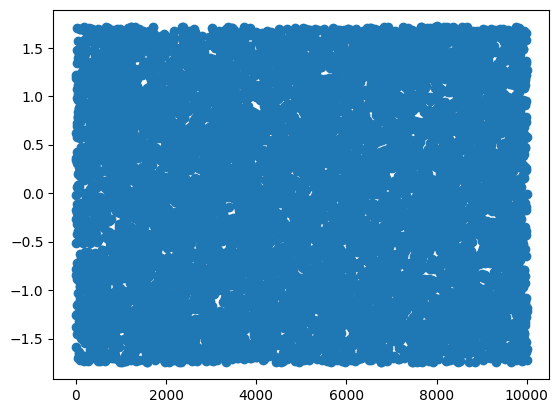

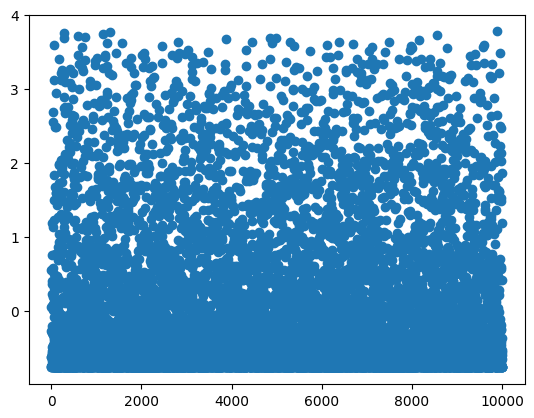

In [19]:
X,Y=create_dataset(10000)
X_train,Y_train,cache_norm=data_nomalization(X,Y,method='std')
x=range(10000)
plt.scatter(x,X_train[1,:])
plt.show()
plt.scatter(x,Y_train[1,:])
plt.show()

In [69]:
### Hyperparameter CONSTANTS ###
layers_dims = [2, 16, 8, 8, 2] #  2-layer model
hidden_layer_activation="tanh" #any of (sigmoid,relu,tanh,linear)
output_layer_activation="linear" #any of (sigmoid,relu,tanh,linear)
norm_method='std'
learning_rate= 0.05
num_iterations=3000
### Train model ###
parameters, costs = L_layer_model(X_train, Y_train, layers_dims,hidden_layer_activation,output_layer_activation,learning_rate, num_iterations, print_cost = True)

Cost after iteration 0: 1.337927999010723
Cost after iteration 100: 0.11443084904696983
Cost after iteration 200: 0.05066167220695379
Cost after iteration 300: 0.03608171916088826
Cost after iteration 400: 0.028448247520145287
Cost after iteration 500: 0.023493722178051273
Cost after iteration 600: 0.019914965880432803
Cost after iteration 700: 0.017175113943417954
Cost after iteration 800: 0.01499620338846389
Cost after iteration 900: 0.013215696867737561
Cost after iteration 1000: 0.011732064053609551
Cost after iteration 1100: 0.01047822541204769
Cost after iteration 1200: 0.009407538424599026
Cost after iteration 1300: 0.008486127971129845
Cost after iteration 1400: 0.007688467304064632
Cost after iteration 1500: 0.006994697800377396
Cost after iteration 1600: 0.0063889439129428145
Cost after iteration 1700: 0.005858228727921516
Cost after iteration 1800: 0.005391761246269175
Cost after iteration 1900: 0.004980455670649399
Cost after iteration 2000: 0.004616596323553673
Cost after 

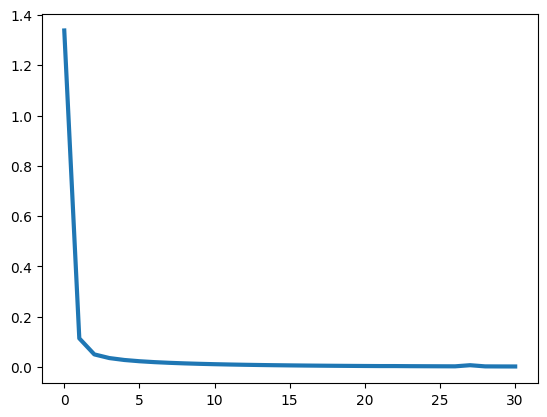

In [70]:
plt.plot(costs)

In [71]:
def predict(X,parameters,cache_norm,norm_method="std"):
    Y_predict=np.zeros_like(X)
    if norm_method =='std':
        X_mean,X_std,Y_mean,Y_std = cache_norm
        X_norm=(X-X_mean)/X_std
        Y_hat,cache=forward_propagation_L_layer(X_norm,parameters,hidden_layer_activation,output_layer_activation)
        Y_predict = Y_hat*Y_std + Y_mean
    elif norm_method == 'max':
        X_max,Y_max = cache_norm
        X_norm=X / X_max
        Y_hat,bin =forward_propagation_L_layer(X_norm,parameters,hidden_layer_activation,output_layer_activation)
        Y_predict = Y_hat*Y_max
    return Y_predict

In [72]:
def r2_score(y_true, y_pred):
    y_mean = np.mean(y_true,axis=1,keepdims=True)
    total_sum_squares = np.sum((y_true - y_mean)**2)
    residual_sum_squares = np.sum((y_true - y_pred)**2)
    r2 = 1 - (residual_sum_squares / total_sum_squares)
    return r2

Create test sets and make prediction

In [73]:
x_test,y_test=create_dataset(1000,random_seed=45)

Remark: this test set has the same distribution as the training set

In [74]:
y_predict= predict(x_test,parameters,cache_norm,norm_method='std')
print( "R-squared Accuracy =" ,r2_score(y_test,y_predict))

R-squared Accuracy = 0.9985783629248084


Well, let plot some graphs, I will vary either scalar or angular, and leave another fixed.

In [75]:
scalar = np.linspace(0 , 40 , 1000).reshape((1,1000))
angular = np.linspace(0 , 90 , 1000).reshape((1,1000))
angular_fixed=[5,25,45,60,75]
scalar_fixed=[5,25,40,50]
offset=len(angular_fixed)
x_test_dict={}
y_test_dict={}
y_predict_dict={}
for i,a in enumerate(angular_fixed):
    x_test_dict["x_test"+str(i)]= np.concatenate((scalar,a*np.ones((1,1000))))
    y_test_dict["y_test"+str(i)]= compute_y(x_test_dict["x_test"+str(i)])
    y_predict_dict["y_predict"+str(i)]=predict(x_test_dict["x_test"+str(i)],parameters,cache_norm,norm_method='std')
for i,s in enumerate(scalar_fixed):
    x_test_dict["x_test"+str(i+offset)]=np.concatenate((s*np.ones((1,1000)),angular))
    y_test_dict["y_test"+str(i+offset)]= compute_y(x_test_dict["x_test"+str(i+offset)])
    y_predict_dict["y_predict"+str(i+offset)]=predict(x_test_dict["x_test"+str(i+offset)],parameters,cache_norm,norm_method='std')

Accuracy of each set when either scalar is fixed or angular is fixed( will later use to plot graph)

In [76]:
for i in range(len(x_test_dict)):
    y_test_temp = y_test_dict["y_test" + str(i)]
    y_predict_temp = y_predict_dict["y_predict" + str(i)]
    m = y_test_temp.shape[1]
    print(f"accuracy of data set{i} (fix angular at {angular_fixed[i]} degree): " if i < offset
          else f"accuracy of data set{i} (fix scalar at {scalar_fixed[i-offset]} m/s): ", r2_score(y_test_temp, y_predict_temp))

accuracy of data set0 (fix angular at 5 degree):  0.9486343146758627
accuracy of data set1 (fix angular at 25 degree):  0.9995918059864428
accuracy of data set2 (fix angular at 45 degree):  0.9992465880891254
accuracy of data set3 (fix angular at 60 degree):  0.9995369362440094
accuracy of data set4 (fix angular at 75 degree):  0.9981679407292263
accuracy of data set5 (fix scalar at 5 m/s):  -0.4938495974415291
accuracy of data set6 (fix scalar at 25 m/s):  0.9971822956736088
accuracy of data set7 (fix scalar at 40 m/s):  0.9919926823550307
accuracy of data set8 (fix scalar at 50 m/s):  0.6960305333292983


The model get worst when apply on the test set that scalar or angular is too low or too high(set0,set5,set8,set9)
Because the scalar of our training set are in range of (0,40) m/s. So this may be an over-fit?

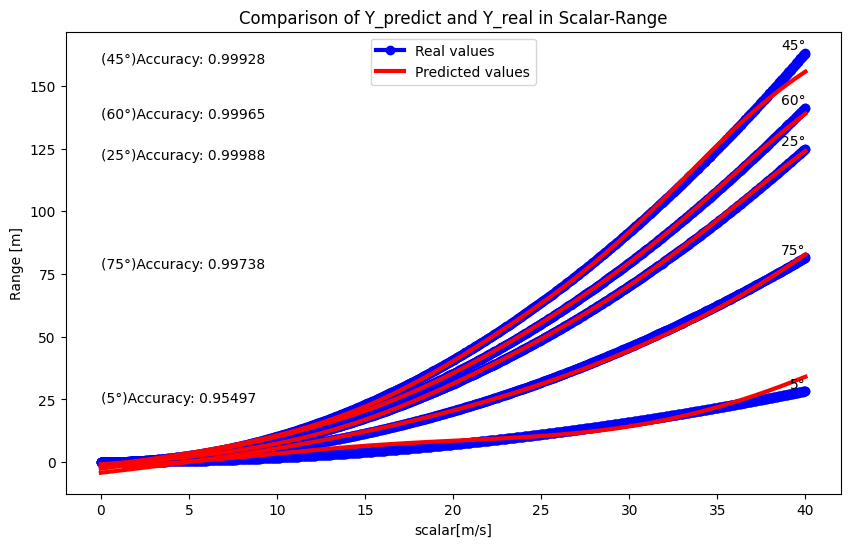

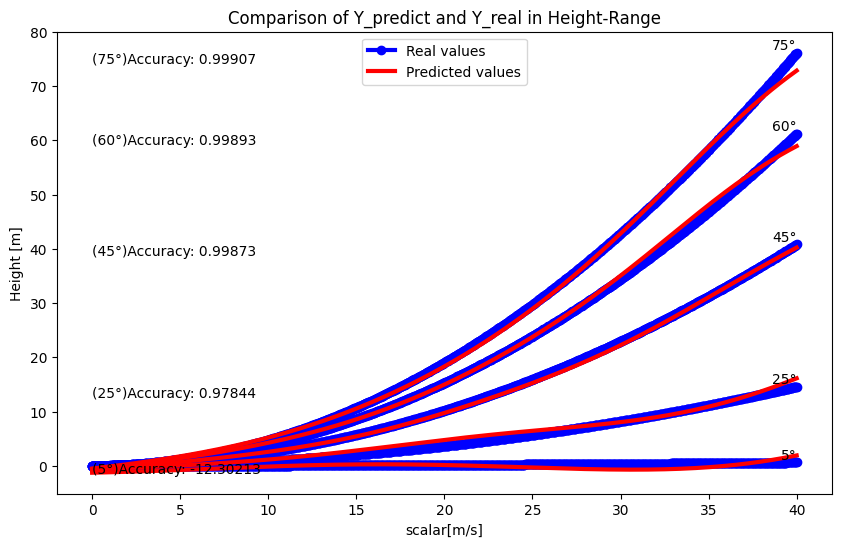

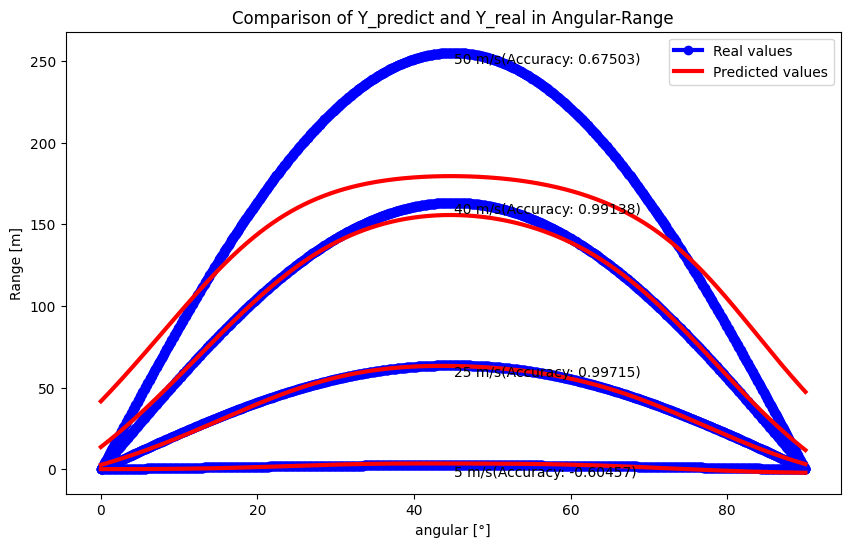

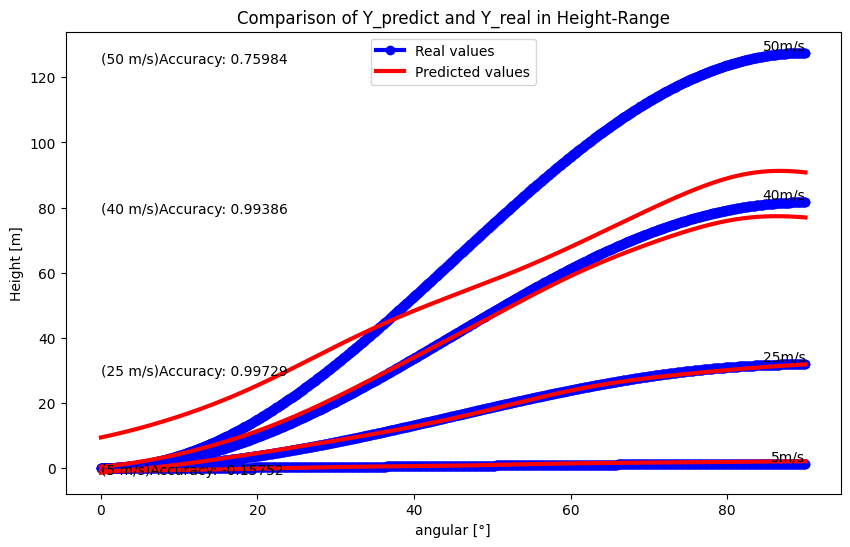

In [77]:
from utils import*
plot_Scalar_Range(x_test_dict,y_test_dict,y_predict_dict,angular_fixed,scalar_fixed)
plot_Scalar_Height(x_test_dict,y_test_dict,y_predict_dict,angular_fixed,scalar_fixed)
plot_Angular_Range(x_test_dict,y_test_dict,y_predict_dict,angular_fixed,scalar_fixed)
plot_Angular_Height(x_test_dict,y_test_dict,y_predict_dict,angular_fixed,scalar_fixed)

The model get worst when apply on the test set that scalar or angular is too low or too high(set0,set5,set8,set9) Because the scalar of our training set are in range of (0,40) m/s. So this may be an over-fit?





Let's try another normalize method

In [86]:
X2,Y2=create_dataset(10000)
X_train2,Y_train2,cache_norm2=data_nomalization(X2,Y2,method="max")

And change the activation function to sigmoid as well

In [97]:
### Hyperparameter CONSTANTS ###
layers_dims = [2, 16, 8, 8,  2] #  2-layer model
hidden_layer_activation="relu" #any of (sigmoid,relu,tanh,linear)
output_layer_activation="linear" #any of (sigmoid,relu,tanh,linear)
learning_rate= 0.05
num_iterations=3000
### Train model ###
parameters2, costs2 = L_layer_model(X_train2, Y_train2, layers_dims,hidden_layer_activation,output_layer_activation,learning_rate, num_iterations, print_cost = True)

Cost after iteration 0: 0.2433825886087337
Cost after iteration 100: 0.0452272151442449
Cost after iteration 200: 0.027104721733736934
Cost after iteration 300: 0.019740203122732884
Cost after iteration 400: 0.016659358487734505
Cost after iteration 500: 0.01467797089646384
Cost after iteration 600: 0.012874518692954437
Cost after iteration 700: 0.011115121785523204
Cost after iteration 800: 0.00953673909760813
Cost after iteration 900: 0.008280346192259355
Cost after iteration 1000: 0.0072363246184940855
Cost after iteration 1100: 0.006343054676782292
Cost after iteration 1200: 0.005576840541302217
Cost after iteration 1300: 0.004929307804595063
Cost after iteration 1400: 0.004371819186804614
Cost after iteration 1500: 0.0038889363376196587
Cost after iteration 1600: 0.0034709015628658457
Cost after iteration 1700: 0.0031071007613761668
Cost after iteration 1800: 0.002793016068283997
Cost after iteration 1900: 0.0025219730672856365
Cost after iteration 2000: 0.0022884500207778604
Cost

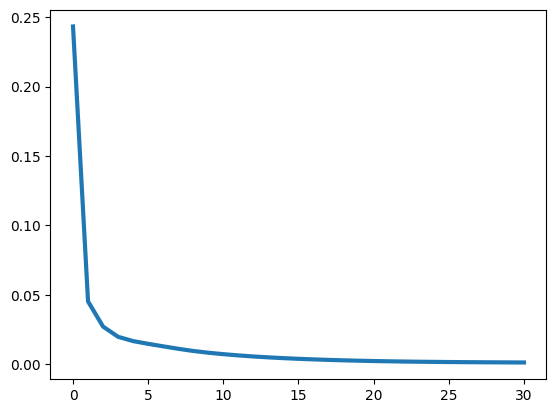

In [98]:
plt.plot(costs2)

In [99]:
x_test2,y_test2=create_dataset(1000,random_seed=55)
y_predict2= predict(x_test2,parameters2,cache_norm2,norm_method='max')
print( "R-squared Accuracy =" ,r2_score(y_test2,y_predict2))

R-squared Accuracy = 0.9859234946578552


In [100]:
scalar = np.linspace(0 , 40 , 1000).reshape((1,1000))
angular = np.linspace(0 , 90 , 1000).reshape((1,1000))
angular_fixed=[5,25,45,60,75]
scalar_fixed=[5,25,40,50]
offset=len(angular_fixed)
x_test_dict2={}
y_test_dict2={}
y_predict_dict2={}
for i,a in enumerate(angular_fixed):
    x_test_dict2["x_test"+str(i)]= np.concatenate((scalar,a*np.ones((1,1000))))
    y_test_dict2["y_test"+str(i)]= compute_y(x_test_dict2["x_test"+str(i)])
    y_predict_dict2["y_predict"+str(i)]=predict(x_test_dict2["x_test"+str(i)],parameters2,cache_norm2,norm_method='max')
for i,s in enumerate(scalar_fixed):
    x_test_dict2["x_test"+str(i+offset)]=np.concatenate((s*np.ones((1,1000)),angular))
    y_test_dict2["y_test"+str(i+offset)]= compute_y(x_test_dict2["x_test"+str(i+offset)])
    y_predict_dict2["y_predict"+str(i+offset)]=predict(x_test_dict2["x_test"+str(i+offset)],parameters2,cache_norm2,norm_method='max')

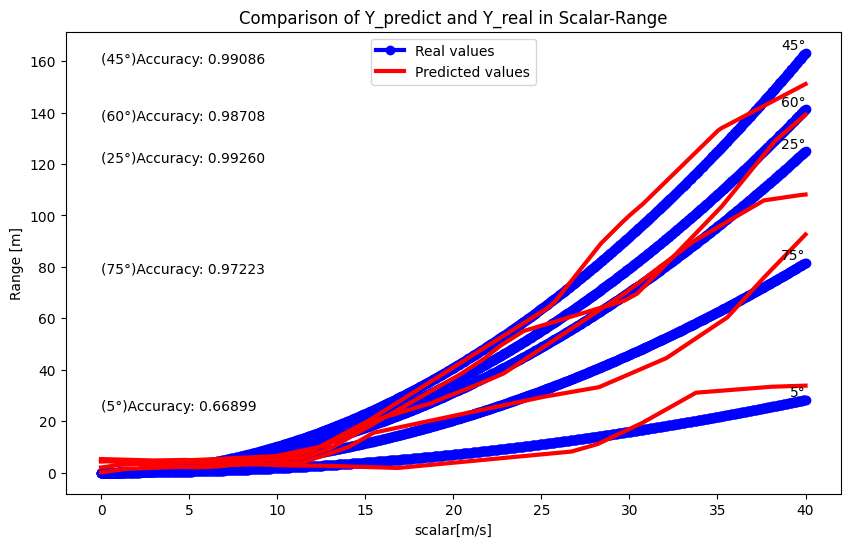

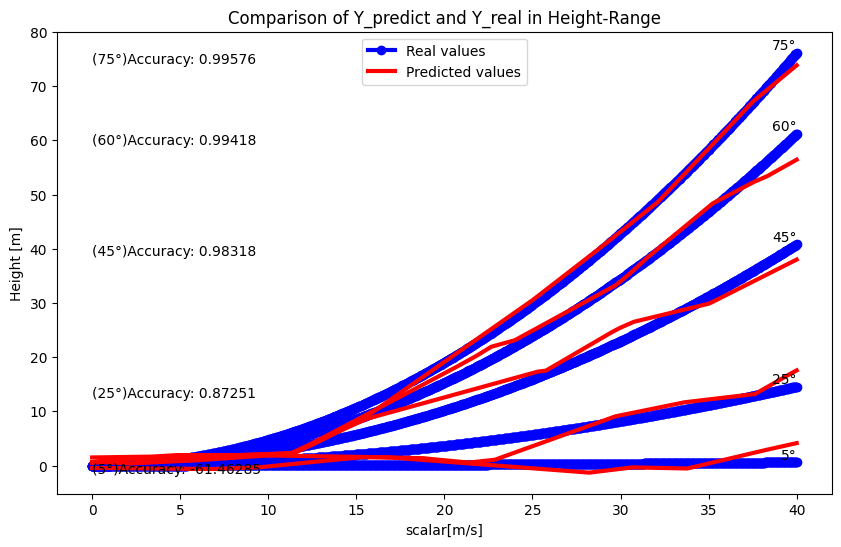

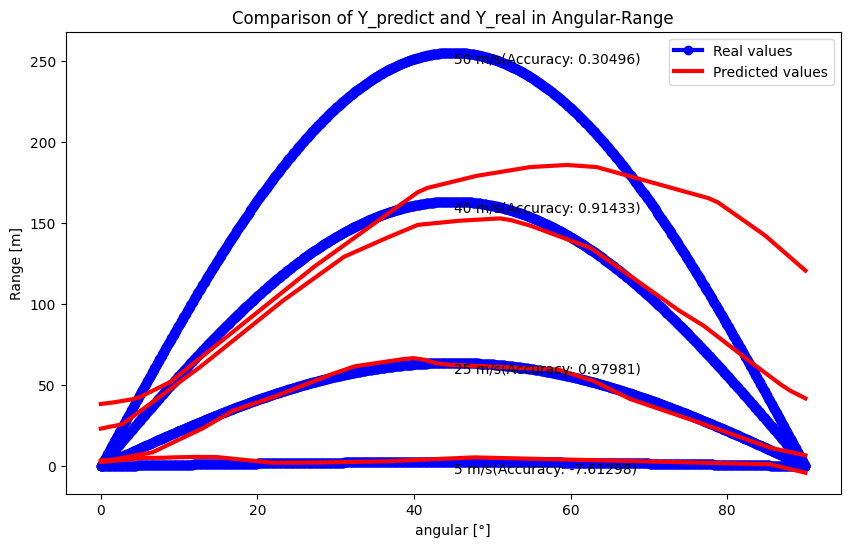

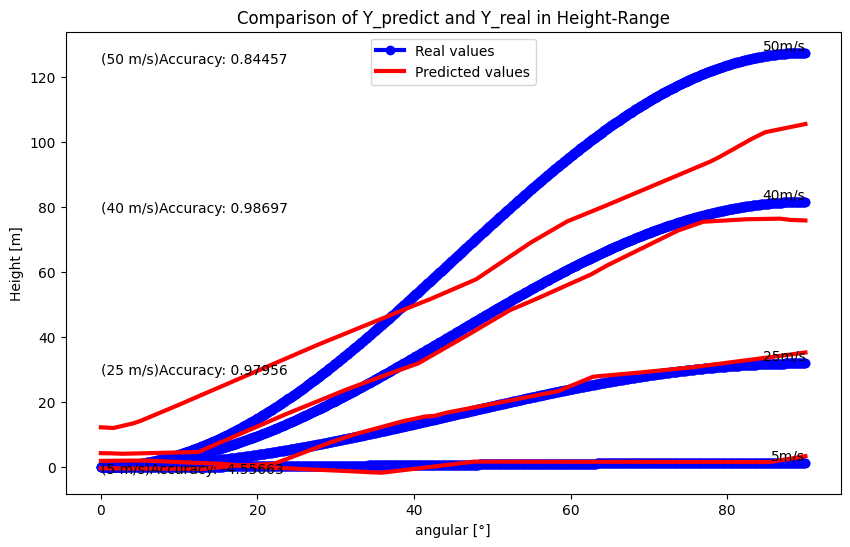

In [101]:
from utils import*
plot_Scalar_Range(x_test_dict2,y_test_dict2,y_predict_dict2,angular_fixed,scalar_fixed)
plot_Scalar_Height(x_test_dict2,y_test_dict2,y_predict_dict2,angular_fixed,scalar_fixed)
plot_Angular_Range(x_test_dict2,y_test_dict2,y_predict_dict2,angular_fixed,scalar_fixed)
plot_Angular_Height(x_test_dict2,y_test_dict2,y_predict_dict2,angular_fixed,scalar_fixed)

Relu is acceptable, but the characteristic of the projectile fit better with tanh rather than ReLU.
normalizing within Max value doesn't give better performance(or even wrost?)